# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [19]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt


from rascil2.data_models import PolarisationFrame

from rascil2.processing_components import create_visibility, show_image, export_image_to_fits, \
    deconvolve_cube, restore_cube, create_named_configuration, create_test_image, \
    create_image_from_visibility, advise_wide_field, invert_ng, predict_ng, \
    plot_uvcoverage, plot_visibility

import logging


log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

In [20]:
from rascil2.processing_components.io import create_visibility_from_ms

In [10]:
import numpy 
a = [[1,2],[3,4]]
b = numpy.array(a, dtype=numpy.int64)
b[0]

array([1, 2])

In [26]:
vt = create_visibility_from_ms("/mnt/storage-main/main/muser-2024/20240424/output/MUSER20240424-023631.ms")[0]

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 5151 rows
create_visibility_from_ms: Found 5151 rows
create_visibility_from_ms: Found 416 channels
create_visibility_from_ms: Found 416 channels
create_visibility_from_ms: Reading all 416 channels
create_visibility_from_ms: Reading all 416 channels
create_visibility_from_ms: Observation from 2024-04-24 02:37:32.975 to 2024-04-24 02:37:32.975
create_visibility_from_ms: Observation from 2024-04-24 02:37:32.975 to 2024-04-24 02:37:32.975


In [27]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1, facets=1, wprojection_planes=1, 
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: (max_wavelength) Maximum wavelength 20.466 (meters)
advise_wide_field: (max_wavelength) Maximum wavelength 20.466 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.725 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.725 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 4073.8 (wavelengths)
advise_wide_field: (maximum_baseline) Maximum baseline 4073.8 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 2544.4 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 2544.4 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 6.0 (meters)
advise_wide_field: (diameter) Station/dish diameter 6.0 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 3.41 (rad) 195 (deg) 7.04e+05 (asec)
advise_wide_field: (primary_beam_fov) Primary beam 3.41 (rad) 195 (deg) 7.04e+05 (asec)
advise_wide_field: (image_fov) Image field of view 10.2 (rad) 586 (deg) 2.11e+06 (asec)
advise_wide_field: (image_fov) Image field of vi

Plot the synthesized uv coverage.

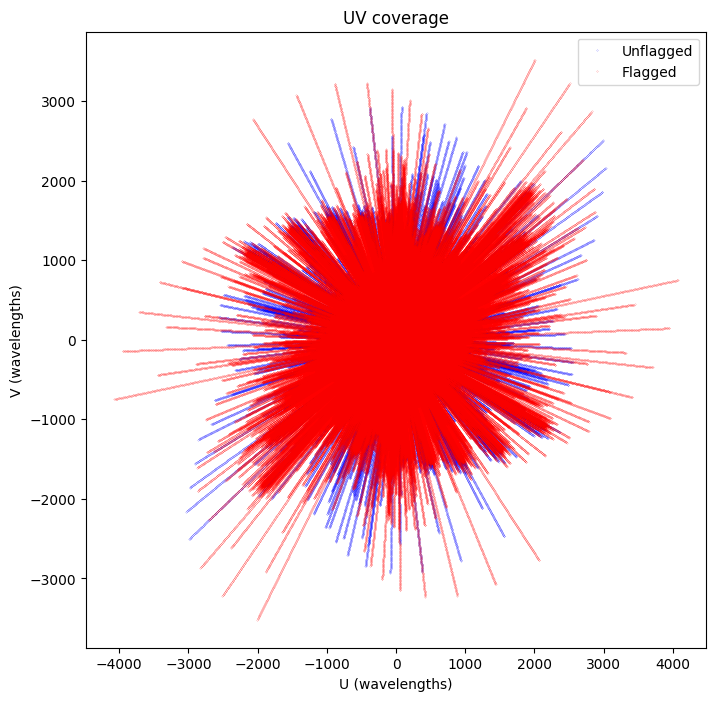

In [5]:
plt.clf()
plot_uvcoverage([vt])
plt.show()

In [6]:
from rascil2.processing_components import flagging_visibility

In [7]:
vtorg = vt.copy(deep=True)

In [8]:
vt = vtorg.copy(deep=True)

In [9]:
import pandas as pd

In [11]:
fd = pd.read_csv("flag_baselines.csv")

In [13]:
vt = flagging_visibility(vt,baselines=list(fd[fd["flag"]==0].index))

Read the venerable test image, constructing an image

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 416 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (32.15019496, 12.99095728)>, starting frequency 14648437.5 Hz, and bandwidth 961538.4615384616 Hz
create_image_from_visibility: uvmax = 4073.759714 wavelengths
create_image_from_visibility: Critical cellsize = 0.000123 radians, 0.007032 degrees
create_image_from_visibility: Cellsize          = 6.13684e-05 radians, 0.00351615 degrees
create_image_from_visibility: image shape is [416, 1, 256, 256]


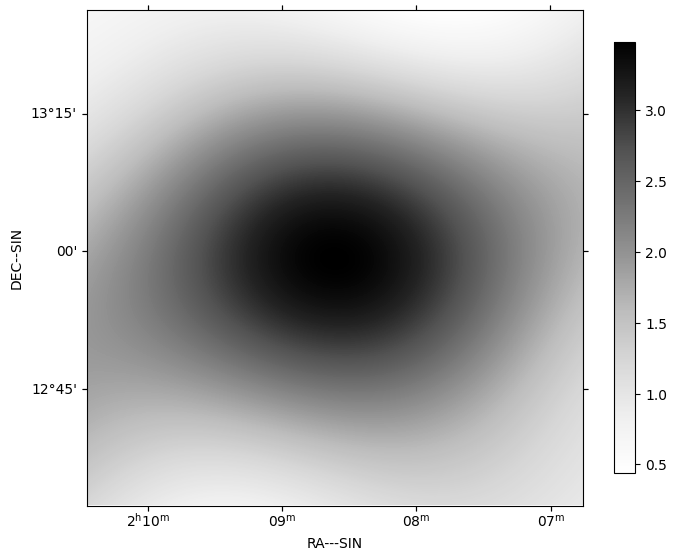

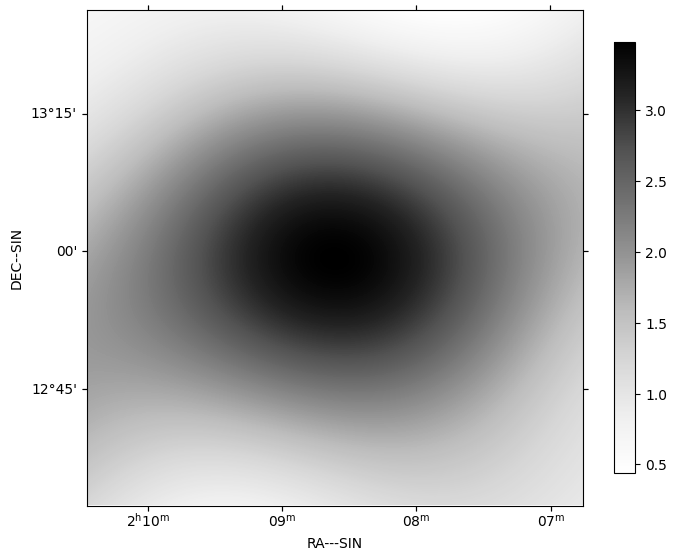

In [14]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=256)
dirty, sumwt = invert_ng(vt, model, context='ng',threads=16)
psf, sumwt = invert_ng(vt, model, context='ng', dopsf=True,threads=16)

show_image(dirty)



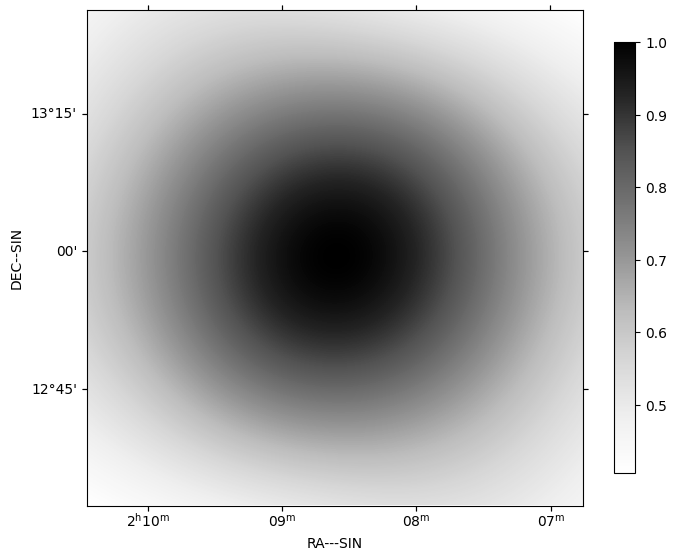

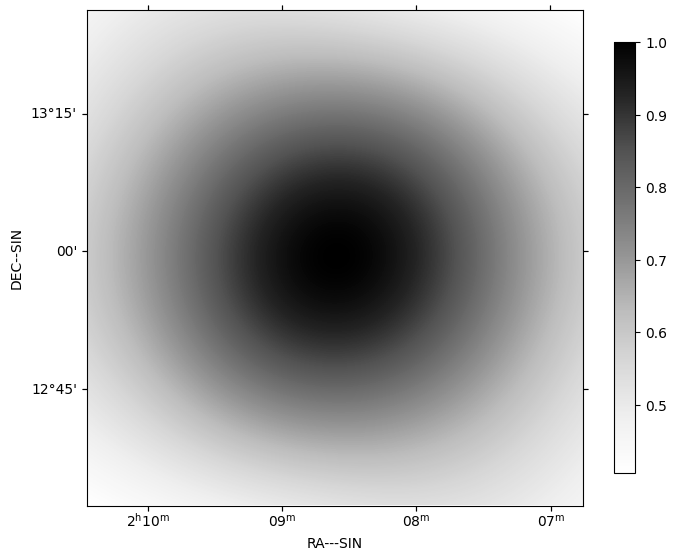

In [17]:
show_image(psf)

In [15]:
results_dir = "./"

In [16]:
export_image_to_fits(dirty, '%s/imaging_dirty256.fits'%(results_dir))
# export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

In [12]:
results_dir

'./'

Deconvolve using clean

In [ ]:
comp, residual = deconvolve_cube(dirty, psf, niter=10000, threshold=0.001, fractional_threshold=0.001,
                                 window_shape='quarter', gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

print(restored)

Predict the visibility of the model

In [ ]:
vtmodel = create_visibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_ng(vtmodel, comp, context='2d')

Now we will plot the original visibility and the residual visibility.

In [ ]:
vtmodel.vis.values = vt.vis.values - vtmodel.vis.values

plt.clf()
plot_visibility([vt, vtmodel], colors=['b', 'r'])
plt.show()

In [11]:
import numpy
a = numpy.array([1,2,3,4])
a

array([1, 2, 3, 4])

In [17]:
b=a.reshape(1,-1)


In [19]:
len(b[0])

4